In [ ]:
%config Completer.use_jedi=False
%matplotlib inline

In [ ]:
import time 
import copy
import glob 
import random

import numpy as np
import pandas as pd
from PIL import Image

from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, resnet34

In [ ]:
train_normal = glob.glob("../data/train/NORMAL/*")
train_pneumonia = glob.glob("../data/train/PNEUMONIA/*")

test_normal = glob.glob("../data/test/NORMAL/*")
test_pneumonia = glob.glob("../data/test/PNEUMONIA/*")

In [ ]:
train_paths = train_normal + train_pneumonia
test_paths = test_normal + test_pneumonia

In [ ]:
train_labels = [0] * len(train_normal) + [1] * len(train_pneumonia)
test_labels = [0] * len(test_normal) + [1] * len(test_pneumonia)

In [ ]:
print(len(train_paths), len(train_labels))
print(len(test_paths), len(test_labels))

5232 5232
624 624


In [ ]:
train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths, 
                                                                        train_labels,
                                                                        stratify=train_labels)

In [ ]:
def show_random_images():
    path_random_normal = random.choice(train_normal)
    path_random_abnormal = random.choice(train_pneumonia)    
    
    fig = plt.figure(figsize=(10, 10))
    
    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(Image.open(path_random_normal).convert("LA"))
    ax1.set_title("Normal X-ray")
    
    ax2 = plt.subplot(1, 2, 2)
    ax2.imshow(Image.open(path_random_abnormal).convert("LA"))
    ax2.set_title("Abnormal X-ray")

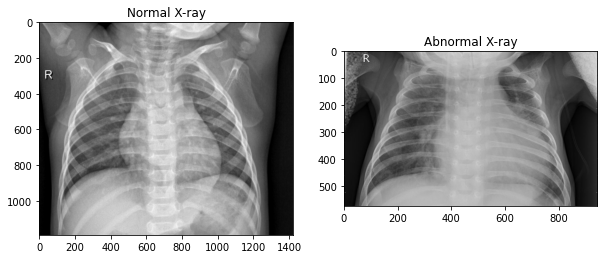

In [ ]:
show_random_images()

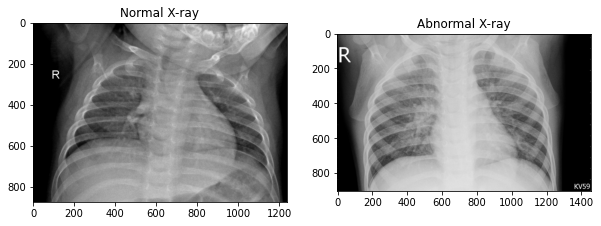

In [ ]:
show_random_images()

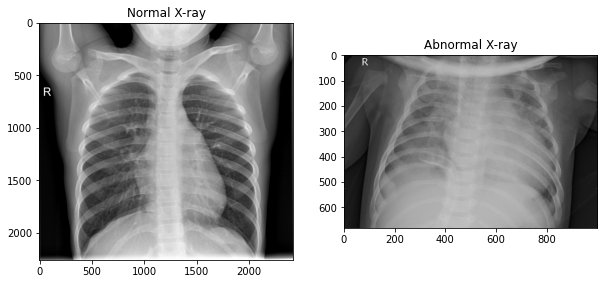

In [ ]:
show_random_images()

In [ ]:
class XrayDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        path = self.paths[index]
        image = Image.open(path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        label = self.labels[index]
        label = torch.tensor([label])
        
        return image, label

In [ ]:
class PneumoniaNet(nn.Module):
    def __init__(self, pretrained=True):
        super(PneumoniaNet, self).__init__()
        self.backbone = resnet18(pretrained=pretrained)
        self.fc = nn.Linear(in_features=512, out_features=1) 
    
    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)        
        x = self.backbone.relu(x)       
        x = self.backbone.maxpool(x)  
        
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)        
        x = self.backbone.layer3(x)        
        x = self.backbone.layer4(x)
        
        x = self.backbone.avgpool(x)
        
        x = x.view(x.size(0), 512)
        x = self.fc(x)
        
        return x

In [ ]:
image_size = (500, 500)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=15),
    transforms.Resize(size=image_size),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=image_size),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = XrayDataset(train_paths, train_labels, train_transform)
valid_dataset = XrayDataset(valid_paths, valid_labels, test_transform)

In [ ]:
pretrained = True

model = PneumoniaNet(pretrained=pretrained)

lr = 3e-3

num_epochs = 5
train_batch_size = 16
valid_batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, num_workers=5, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=valid_batch_size, num_workers=5, shuffle=False)


dataloaders = {
    "train": train_dataloader,
    "val": valid_dataloader
}

logging_steps = {
    "train": len(dataloaders["train"]) // 10,
    "val": len(dataloaders["val"]) // 10
}

dataset_sizes = {
    "train": len(train_dataset),
    "val": len(valid_dataset)
}

batch_sizes = {
    "train": train_batch_size,
    "val": valid_batch_size
}

criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=lr)

In [ ]:
model.cuda()

PneumoniaNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
! nvidia-smi

Wed Apr 21 22:33:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   38C    P2    60W / 260W |    829MiB / 11176MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
def train_model(model, criterion, optimizer, num_epochs, device="cuda"):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0
    
    for epoch in tqdm(range(num_epochs), leave=False):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for i, (inputs, labels) in tqdm(enumerate(dataloaders[phase]), 
                                            leave=False, 
                                            total=len(dataloaders[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    
                    preds = outputs.sigmoid() > 0.5
                    loss = criterion(outputs, labels.float())
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                if (i % logging_steps[phase] == 0) & (i > 0):
                    avg_loss = running_loss / ((i+1) * batch_sizes[phase])
                    avg_acc = running_corrects / ((i+1) * batch_sizes[phase])   
                    
                    print(f"[{phase}]: {epoch+1} / {num_epochs} | loss : {avg_loss} | acc : {avg_acc}")
                    
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
    time_elapsed = time.time() - since
    
    print(f"training took {time_elapsed} seconds")
    
    model.load_state_dict(best_model_wts)
    
    return model

In [ ]:
model = train_model(model, criterion, optimizer, num_epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

[train]: 1 / 5 | loss : 0.45857274770736695 | acc : 0.8025000095367432
[train]: 1 / 5 | loss : 0.37670772841998507 | acc : 0.8405612111091614
[train]: 1 / 5 | loss : 0.35020867265658834 | acc : 0.8493150472640991
[train]: 1 / 5 | loss : 0.33534671035931285 | acc : 0.8530927300453186
[train]: 1 / 5 | loss : 0.31844936342032487 | acc : 0.8667355179786682
[train]: 1 / 5 | loss : 0.31601652025148785 | acc : 0.8681034445762634
[train]: 1 / 5 | loss : 0.31668360244769317 | acc : 0.8668639063835144
[train]: 1 / 5 | loss : 0.3118761160020075 | acc : 0.8691709637641907
[train]: 1 / 5 | loss : 0.30184386589903434 | acc : 0.872407853603363
[train]: 1 / 5 | loss : 0.3010240705583353 | acc : 0.8742220401763916
train Loss: 0.3003 Acc: 0.8749


  0%|          | 0/82 [00:00<?, ?it/s]

[val]: 1 / 5 | loss : 9.957773950364855 | acc : 0.2569444477558136
[val]: 1 / 5 | loss : 9.7984060680165 | acc : 0.25735294818878174
[val]: 1 / 5 | loss : 9.784798221588135 | acc : 0.2574999928474426
[val]: 1 / 5 | loss : 9.551229332432602 | acc : 0.26893940567970276
[val]: 1 / 5 | loss : 9.542146287313322 | acc : 0.269817054271698
[val]: 1 / 5 | loss : 9.518767026005959 | acc : 0.27933672070503235
[val]: 1 / 5 | loss : 9.617659434937595 | acc : 0.2774122953414917
[val]: 1 / 5 | loss : 9.73875527015099 | acc : 0.27019229531288147
[val]: 1 / 5 | loss : 9.7874062551211 | acc : 0.26198628544807434
[val]: 1 / 5 | loss : 9.661087654255054 | acc : 0.26620370149612427
val Loss: 9.6832 Acc: 0.2645



  0%|          | 0/246 [00:00<?, ?it/s]

[train]: 2 / 5 | loss : 0.2147027763724327 | acc : 0.92249995470047
[train]: 2 / 5 | loss : 0.24249445190843272 | acc : 0.9068877100944519
[train]: 2 / 5 | loss : 0.25998963558510557 | acc : 0.8989725708961487
[train]: 2 / 5 | loss : 0.25073237824685796 | acc : 0.8994845151901245
[train]: 2 / 5 | loss : 0.2456680721611031 | acc : 0.9044421315193176
[train]: 2 / 5 | loss : 0.25095092356204984 | acc : 0.9034482836723328
[train]: 2 / 5 | loss : 0.24711256022372188 | acc : 0.9031065106391907
[train]: 2 / 5 | loss : 0.24317561470242363 | acc : 0.9041450619697571
[train]: 2 / 5 | loss : 0.24757924093972153 | acc : 0.9029377698898315
[train]: 2 / 5 | loss : 0.2435636639718693 | acc : 0.9040457010269165
train Loss: 0.2412 Acc: 0.9052


  0%|          | 0/82 [00:00<?, ?it/s]

[val]: 2 / 5 | loss : 0.17032616999414232 | acc : 0.9027777910232544
[val]: 2 / 5 | loss : 0.19401806483373923 | acc : 0.9338235259056091
[val]: 2 / 5 | loss : 0.22032107703387738 | acc : 0.9325000047683716
[val]: 2 / 5 | loss : 0.23287139420933795 | acc : 0.9280303120613098
[val]: 2 / 5 | loss : 0.23679547993148245 | acc : 0.9237804412841797
[val]: 2 / 5 | loss : 0.23097316388572967 | acc : 0.9234693646430969
[val]: 2 / 5 | loss : 0.21805892463185286 | acc : 0.9276315569877625
[val]: 2 / 5 | loss : 0.20839041947172238 | acc : 0.9307692050933838
[val]: 2 / 5 | loss : 0.19811522006376148 | acc : 0.9357876777648926
[val]: 2 / 5 | loss : 0.20724722324514094 | acc : 0.9344136118888855
val Loss: 0.2060 Acc: 0.9350



  0%|          | 0/246 [00:00<?, ?it/s]

[train]: 3 / 5 | loss : 0.194811070561409 | acc : 0.9249999523162842
[train]: 3 / 5 | loss : 0.19512205859836268 | acc : 0.9247449040412903
[train]: 3 / 5 | loss : 0.2154401640267405 | acc : 0.9169520735740662
[train]: 3 / 5 | loss : 0.2159840199597103 | acc : 0.9149484038352966
[train]: 3 / 5 | loss : 0.20869767730516836 | acc : 0.9194214344024658
[train]: 3 / 5 | loss : 0.20963681427569225 | acc : 0.9206896424293518
[train]: 3 / 5 | loss : 0.19766635652741738 | acc : 0.9264053106307983
[train]: 3 / 5 | loss : 0.1952495749055413 | acc : 0.9271372556686401
[train]: 3 / 5 | loss : 0.19739841323878085 | acc : 0.9268433451652527
[train]: 3 / 5 | loss : 0.19395774112110067 | acc : 0.9286826252937317
train Loss: 0.1961 Acc: 0.9274


  0%|          | 0/82 [00:00<?, ?it/s]

[val]: 3 / 5 | loss : 0.31019744152824086 | acc : 0.8472222089767456
[val]: 3 / 5 | loss : 0.3129824428435634 | acc : 0.8345588445663452
[val]: 3 / 5 | loss : 0.28315197184681895 | acc : 0.8574999570846558
[val]: 3 / 5 | loss : 0.28599117730151524 | acc : 0.8636363744735718
[val]: 3 / 5 | loss : 0.29248632808647507 | acc : 0.8643292188644409
[val]: 3 / 5 | loss : 0.3256522075710248 | acc : 0.8533163070678711
[val]: 3 / 5 | loss : 0.3267713340097352 | acc : 0.8552631735801697
[val]: 3 / 5 | loss : 0.32562439596423737 | acc : 0.857692301273346
[val]: 3 / 5 | loss : 0.3122208057711386 | acc : 0.863869845867157
[val]: 3 / 5 | loss : 0.3070186200425213 | acc : 0.8680555820465088
val Loss: 0.3076 Acc: 0.8685



  0%|          | 0/246 [00:00<?, ?it/s]

[train]: 4 / 5 | loss : 0.23254912823438645 | acc : 0.9099999666213989
[train]: 4 / 5 | loss : 0.20543932770283854 | acc : 0.9196428656578064
[train]: 4 / 5 | loss : 0.2064600013553688 | acc : 0.920376718044281
[train]: 4 / 5 | loss : 0.20416065307391673 | acc : 0.9207473993301392
[train]: 4 / 5 | loss : 0.20076892389492554 | acc : 0.9194214344024658
[train]: 4 / 5 | loss : 0.2084481325642816 | acc : 0.9150862097740173
[train]: 4 / 5 | loss : 0.20001622849314876 | acc : 0.9193786978721619
[train]: 4 / 5 | loss : 0.2054623351890806 | acc : 0.9206606149673462
[train]: 4 / 5 | loss : 0.19926823860180268 | acc : 0.9222350120544434
[train]: 4 / 5 | loss : 0.19123512875149606 | acc : 0.9250519275665283
train Loss: 0.1903 Acc: 0.9256


  0%|          | 0/82 [00:00<?, ?it/s]

[val]: 4 / 5 | loss : 0.8781043092409769 | acc : 0.75
[val]: 4 / 5 | loss : 0.8808470122954425 | acc : 0.7463235259056091
[val]: 4 / 5 | loss : 0.9038100528717041 | acc : 0.7450000047683716
[val]: 4 / 5 | loss : 0.9360205336953654 | acc : 0.7348484992980957
[val]: 4 / 5 | loss : 0.9389559986387811 | acc : 0.7362804412841797
[val]: 4 / 5 | loss : 0.9567016712865051 | acc : 0.7295918464660645
[val]: 4 / 5 | loss : 0.9450772820334685 | acc : 0.7313596606254578
[val]: 4 / 5 | loss : 0.9181315071486796 | acc : 0.737500011920929
[val]: 4 / 5 | loss : 0.8970297356742141 | acc : 0.7457191944122314
[val]: 4 / 5 | loss : 0.9138114160001508 | acc : 0.7422839403152466
val Loss: 0.9089 Acc: 0.7439



  0%|          | 0/246 [00:00<?, ?it/s]

[train]: 5 / 5 | loss : 0.16308694183826447 | acc : 0.9375
[train]: 5 / 5 | loss : 0.1620012274087996 | acc : 0.9375
[train]: 5 / 5 | loss : 0.17319895415120337 | acc : 0.9349315166473389
[train]: 5 / 5 | loss : 0.15821760857343367 | acc : 0.9407216310501099
[train]: 5 / 5 | loss : 0.16359960678041227 | acc : 0.9395660758018494
[train]: 5 / 5 | loss : 0.16373683665076205 | acc : 0.9383620619773865
[train]: 5 / 5 | loss : 0.16505665707914435 | acc : 0.9367603659629822
[train]: 5 / 5 | loss : 0.16442565470354853 | acc : 0.9365284442901611
[train]: 5 / 5 | loss : 0.1592944525611428 | acc : 0.9389401078224182
[train]: 5 / 5 | loss : 0.163778956902225 | acc : 0.9380187392234802
train Loss: 0.1637 Acc: 0.9381


  0%|          | 0/82 [00:00<?, ?it/s]

[val]: 5 / 5 | loss : 3.181587689452701 | acc : 0.4305555522441864
[val]: 5 / 5 | loss : 3.189167692380793 | acc : 0.4154411852359772
[val]: 5 / 5 | loss : 3.0856729483604433 | acc : 0.4025000035762787
[val]: 5 / 5 | loss : 2.97984742937666 | acc : 0.41856062412261963
[val]: 5 / 5 | loss : 2.979654642139993 | acc : 0.4176829159259796
[val]: 5 / 5 | loss : 3.025585100358846 | acc : 0.419642835855484
[val]: 5 / 5 | loss : 3.0727421181243764 | acc : 0.41995614767074585
[val]: 5 / 5 | loss : 3.0926700399472162 | acc : 0.4115384519100189
[val]: 5 / 5 | loss : 3.1019429760436488 | acc : 0.4023972451686859
[val]: 5 / 5 | loss : 3.0583448137766047 | acc : 0.4089506268501282
val Loss: 3.0606 Acc: 0.4083

training took 437.52808475494385 seconds


In [ ]:
test_paths = glob.glob("../data/test/NORMAL/*") + glob.glob("../data/test/PNEUMONIA/*")
test_labels = [0] * len(glob.glob("../data/test/NORMAL/*")) + [1] * len(glob.glob("../data/test/PNEUMONIA/*"))

In [ ]:
len(test_paths), len(test_labels)

(624, 624)

In [ ]:
test_dataset = XrayDataset(test_paths, test_labels, test_transform)

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False)

In [ ]:
y_pred = []
y_true = []

for i, (tensors, labels) in tqdm(enumerate(test_dataloader), leave=False, total=len(test_dataloader)):
    with torch.no_grad():
        predictions = model(tensors.cuda())
        predictions = predictions.sigmoid()
        predictions = predictions > 0.5
        y_pred.append(predictions)
        
        y_true.append(labels)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
y_pred = torch.cat(y_pred)
y_true = torch.cat(y_true)

In [ ]:
y_pred.shape, y_true.shape,

(torch.Size([624, 1]), torch.Size([624, 1]))

In [ ]:
y_pred = y_pred.cpu().numpy()
y_true = y_true.numpy()

In [ ]:
y_pred = y_pred.astype(np.int64)
y_true = y_true.astype(np.int64)

In [ ]:
y_pred = y_pred.reshape(-1)
y_true = y_true.reshape(-1)

In [ ]:
y_pred.shape, y_true.shape

((624,), (624,))

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_true, y_pred)

0.7676282051282052